# Mini-Project 2: Source extraction

**Context**

This notebook illustrates the basics of distributing image data, and process them separately. In this notebook, we will load [MegaCam](https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/) data, and extract source positions in the images.

**Learning objectives**

After going through this notebook, you should be able to:

- Load and efficiently access astronomical images with Apache Spark
- Interface and use your favourite image processing package.

For this project, you will use the data at `data/images` (see the `download_data_project.sh` script).

In [1]:
# We use the custom spark-fits connector
df = spark.read.format("fits").option("hdu", 1).load("../data/images/*.fits")

In [2]:
df.show(3)

+--------------------+
|               Image|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 3 rows



By default, spark-fits will assign one image line per row, without specifying the data provenance. But you can retrieve it  easily:

In [3]:
from pyspark.sql.functions import input_file_name

df = df.withColumn('ImgIndex', input_file_name())

df.show(3)

+--------------------+--------------------+
|               Image|            ImgIndex|
+--------------------+--------------------+
|[0.0, 0.0, 0.0, 0...|file:/home/jovyan...|
|[0.0, 0.0, 0.0, 0...|file:/home/jovyan...|
|[0.0, 0.0, 0.0, 0...|file:/home/jovyan...|
+--------------------+--------------------+
only showing top 3 rows



We have 4 images with 4644 lines each:

In [4]:
df.groupBy('ImgIndex').count().show()

+--------------------+-----+
|            ImgIndex|count|
+--------------------+-----+
|file:/home/jovyan...| 4644|
|file:/home/jovyan...| 4644|
|file:/home/jovyan...| 4644|
|file:/home/jovyan...| 4644|
+--------------------+-----+



and for each image, we have 2112 columns:

In [5]:
import pandas as pd
from pyspark.sql.functions import pandas_udf

@pandas_udf('int')
def count_col(col: pd.Series) -> pd.Series:
    return pd.Series(col.apply(lambda x: len(x)))

df.withColumn('ncolumns', count_col(df['Image'])).select('ncolumns').distinct().show()

+--------+
|ncolumns|
+--------+
|    2112|
+--------+



**Exercise:** Using [photutils](https://photutils.readthedocs.io/en/stable/index.html) (or whatever you prefer), extract the position of sources in the images whose peak value is 50-sigma above the background.

In [6]:
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import numpy as np
import pandas as pd

from photutils import DAOStarFinder
from photutils import CircularAperture

from pyspark.sql.types import FloatType, ArrayType
from pyspark.sql.functions import pandas_udf, PandasUDFType

from typing import Iterator, Generator


def get_stat(data, sigma=3.0, iters=3):
    """ Estimate the background and background noise using
    sigma-clipped statistics.
    
    Parameters
    ----------
    data : 2D array
        2d array containing the data.
    sigma : float
        sigma.
    iters : int
        Number of iteration to perform to get accurate estimate.
        The higher the better, but it will be longer.
    """
    mean, median, std = sigma_clipped_stats(data, sigma=sigma, maxiters=iters)
    return mean, median, std

def extract_catalog(pdf: pd.DataFrame) -> pd.DataFrame:
    """ Use photutils to extract source information 
    from image (one image per partition).
    """
    # Reshape images for photutils
    image = np.array(
        [np.array(j, dtype=float) for j in pdf['Image'].values],
        dtype=float
    )

    # Get background statistics
    mean, median, std = get_stat(image)

    # Use star finder
    sf = DAOStarFinder(fwhm=10.0, threshold=50.*std)
    cat = sf(image - median)
    
    pdf_to_return = cat.to_pandas()
    pdf_to_return['ImgIndex'] = pdf['ImgIndex'].values[0]

    return pdf_to_return

In [7]:
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType

# Define the output schema (catalog from photutils)
schema = StructType(
    [
        StructField('id', IntegerType(), True),
        StructField('xcentroid', FloatType(), True),
        StructField('ycentroid', FloatType(), True),
        StructField('sharpness', FloatType(), True),
        StructField('roundness1', FloatType(), True),
        StructField('roundness2', FloatType(), True),
        StructField('npix', IntegerType(), True),
        StructField('sky', FloatType(), True),
        StructField('peak', FloatType(), True),
        StructField('flux', FloatType(), True),
        StructField('mag', FloatType(), True),
        StructField('ImgIndex', StringType(), True)
    ]
)


catalog = df.groupBy('ImgIndex').applyInPandas(extract_catalog, schema=schema)

In [8]:
catalog.show()

+---+---------+---------+----------+-------------+------------+----+---+---------+---------+-----------+--------------------+
| id|xcentroid|ycentroid| sharpness|   roundness1|  roundness2|npix|sky|     peak|     flux|        mag|            ImgIndex|
+---+---------+---------+----------+-------------+------------+----+---+---------+---------+-----------+--------------------+
|  1|1388.8229|18.493221| 0.7689446|  0.046623383|-0.002338179| 169|0.0| 479.4004|1.4159424|-0.37761402|file:/home/jovyan...|
|  2| 848.0338|  85.5593| 0.9693655|   -0.3904222| 0.057459183| 169|0.0| 577.3203|1.1877618|-0.18682332|file:/home/jovyan...|
|  3|1035.3126| 86.18903| 0.7991641|  -0.05152344| 0.109907895| 169|0.0|1368.8398|3.3767831|  -1.321258|file:/home/jovyan...|
|  4| 1778.577| 97.06648|0.66756994|    0.2465953|  0.39156005| 169|0.0| 570.1797|1.2222672| -0.2179153|file:/home/jovyan...|
|  5|852.81885|103.88341|0.38213226|  -0.11034597|  0.14786954| 169|0.0| 65197.38| 281.8474| -6.1250353|file:/home/jov

## Plotting results

In [9]:
# retrieve image indices
indices = df.select('ImgIndex').distinct().collect()[0]

# retrieve the first image to the driver
first_image = df.filter(df['ImgIndex'] == indices[0]).select('Image').collect()

# retrieve the first catalog of sources to the driver
first_catalog = catalog.filter(catalog['ImgIndex'] == indices[0]).toPandas()

<ipython-input-37-39b46d3402ab>:10: RuntimeWarning: divide by zero encountered in log
  data = np.log(data)


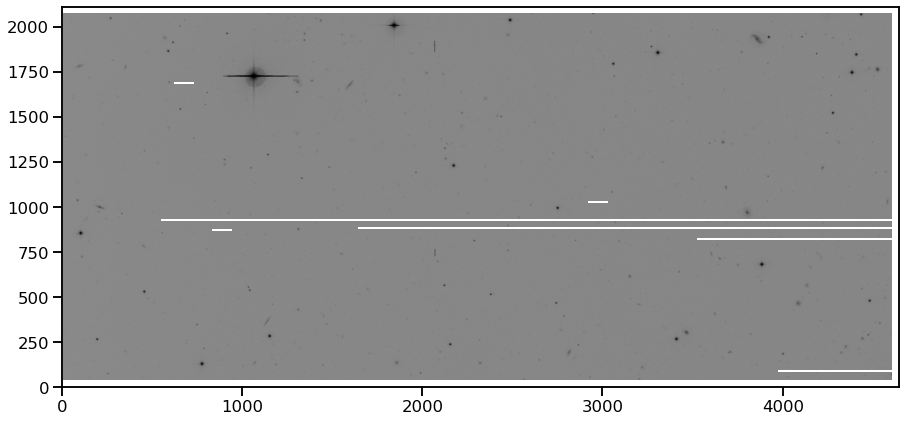

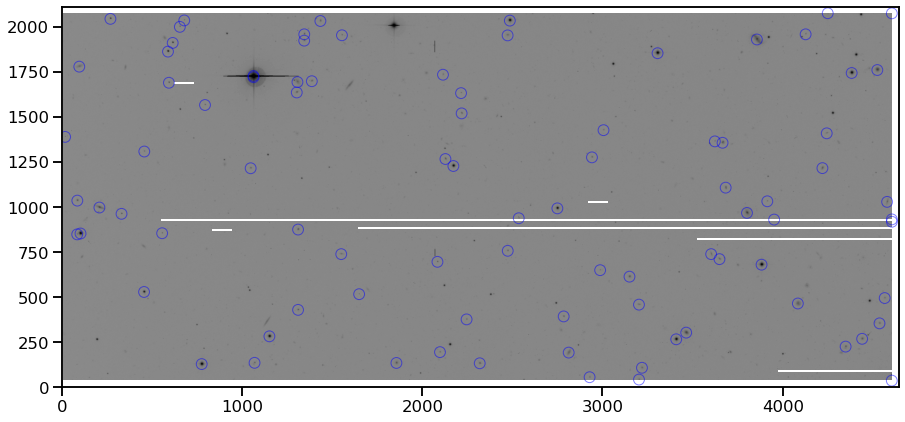

In [37]:
# Overplot detections on the images
from astropy.visualization import AsinhStretch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

data = np.transpose(first_image).reshape((2112, 4644))

# only for visualisation purposes!
data = np.log(data)
norm = ImageNormalize(stretch=AsinhStretch())

fig = plt.figure(0, (15, 15))

plt.imshow(data, cmap='binary', origin="lower", norm=norm)
plt.show()

fig = plt.figure(0, (15, 15))

positions = [[y, x] for y, x in zip(first_catalog['ycentroid'].values, first_catalog['xcentroid'].values)]
apertures = CircularAperture(positions, r=30.)

plt.imshow(data, cmap='binary', origin="lower", norm=norm)
apertures.plot(color='blue', lw=1.0, alpha=0.5);